# n-widths for transport problems 
## Heaviside step function
$u(x;\mu) = f(x, \mu) = \begin{cases}
    0.0 & \text{if $x < \mu $} \\
    0.5 & \text{if $x = \mu $} \\
    1.0 & \text{if $x > \mu $}
  \end{cases}$ 
  
  $ x \in ({0,1})$ and $ \mu \in ({0,1})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, orth, qr
from scipy.optimize import curve_fit
from numpy import sin, cos, pi
cmap = plt.cm.plasma

In [2]:
class Domain:
    def __init__(self, bounds, size):
        self.bounds = bounds
        self.size = size
        self.min, self.max = bounds[0], bounds[1]
        T = self.max - self.min
        self.delta_x = dx = T/size
        self.x = np.linspace(self.min+dx/2, self.max-dx/2, size)
        return

    def __call__(self):
        return self.x


class Function:
    name = None

    def __init__(self):
        return

    def __call__(self, x, mu):
        if isinstance(mu, float):
            return self.u(x, mu)
        m, n = x.size, mu.size
        X = np.zeros((m, n))  # snapshot matrix
        for j, mu_j in enumerate(mu):
            X[:, j] = self.u(x, mu_j)
        return X

    def u(self, x, mu):
        return

    def plot(self, x):
        test_sample = x.size//2
        mu = x[test_sample]
        print(mu)
        fig, ax = plt.subplots()
        ax.plot(x, u(x, mu), ".")
        ax.set_xlabel("x")
        ax.set_ylabel("u(x; mu={:.4f})".format(mu))
        plt.show()


In [3]:
class Heaviside(Function):
    name = "heaviside"

    def u(self, x, mu):
        y = np.zeros_like(x)
        y[x < mu] = 0.0
        y[x == mu] = .5
        y[x > mu] = 1.0
        return y


In [4]:
def normalize(U):
    U_n = U / np.sum(U**2, axis=0)**.5
    return U_n


def rms(difference):
    L2 = np.mean(difference**2, axis=0)**.5
    return L2


def projection_error(X, basis):
    difference = X - (basis @ basis.T) @ X
    return rms(difference)


class Basis:
    def __init__(self):
        return

    def reduced_basis(self, rank):
        # truncation
        return self.U[:, :rank]

    def calc_error(self, X_test, r_max=None):
        M, N = X_test.shape
        if not r_max:
            r_max = N if N < M else M
        rms_error = np.zeros((r_max,))
        max_error = np.zeros((r_max,))
        for r in range(1, r_max//1, r_max//100):
            U_r = self.reduced_basis(rank=r)
            L2 = projection_error(X_test, U_r)
            rms_error[r] = np.sqrt(np.mean(L2**2))
            max_error[r] = L2.max()
        return rms_error, max_error

In [5]:
class SVD(Basis):
    name = "svd"

    def __init__(self, X):
        # based on snapshots X
        U, S, VT = np.linalg.svd(X, full_matrices=False)
        is_flipped = VT[:, 1] < 0
        U[:, is_flipped] *= -1
        VT[is_flipped, :] *= -1
        self.U = U
        self.S = S
        self.VT = VT
        return None


class Trigonometric(Basis):
    name = "trigonometric"

    def __init__(self, domain, fun=np.sin, r=None):
        # based on analytic sine functions
        m = domain.size
        if not r:
            r = m
        U = np.zeros((m, r))
        T = domain.max-domain.min
        delta_x = domain.delta_x
        A = 2*delta_x**0.5 * np.sin(np.pi/4)
        x = domain()
        for i in range(r):
            omega = 2 * np.pi/(4*T) * (2*i+1)
            U[:, i] = A * fun(omega*x)
        self.U = normalize(U)
        return


class Greedy(Basis):
    name = "greedy"

    def __init__(self, X, r=None):
        # based on snapshots X
        print("generating greedy basis. rank: ")
        m, n = X.shape
        if not r:
            r = min(m, n)
        U = np.zeros_like(X[:, 0, None])
        err = np.zeros(r,)
        for i in range(r):
            print(i, end=", ")
            psi_i, err[i] = self.next_basis_vec(X, U)
            U = np.c_[U, psi_i]
        print()
        self.U = U
        return

    def next_basis_vec(self, X, U):
        error = X - U @ (U.T @ X)
        L2 = np.mean(error**2, axis=0)**.5
        worst = np.argmax(L2)
        return normalize(error[:, worst]), L2[worst]


class LNA(Basis):
    name = "local neighbours average"

    def __init__(self, u, domain):
        # based on the snapshot generating function u
        self.u = u
        self.domain = domain

    def reduced_basis(self, rank):
        x = self.domain()
        r = rank
        m, n = x.size, r+1
        dm = 1/n
        mu = np.linspace(dm/2, 1-dm/2, n)
        X = np.zeros((m, n))  # snapshot matrix
        for j, mu_j in enumerate(mu):
            X[:, j] = self.u(x, mu_j)
        W = (X[:, :-1]+X[:, 1:])/2
        Q, R = qr(W, mode="economic")
        self.basis = Q
        return Q


class LPF(Basis):
    name = "local pulse functions"

    def __init__(self, domain):
        # based on the snapshot generating function u
        self.domain = domain

    def reduced_basis(self, rank):
        x = self.domain()
        r = rank
        m = x.size
        U = np.zeros((m, r))
        for i in range(r):
            is_one = (i/r <= x) & (x < (i+1)/r)
            U[is_one, i] = 1.0
        assert np.all(np.sum(U, axis=1) == 1), "not orthogonal"
        return normalize(U)

We need to set some boring plotting options...:

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')

8.030570172000001


In [7]:
def plot_modes(x, X, r=10):
    for i in range(r):
        plt.plot(x, X[:, i], "o", ms=1, color=cmap(i/r))
    plt.xlim([0, 1])
    plt.grid(which="both")
    return


def plot_singular_values(S):
    S = S/S[0]  # normalize singular values to make for a better comparison!
    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(1, len(S)+1), S, "k.", ms=1)
    ax1.set_xlabel("order")
    ax1.set_ylabel("singular value")
    ax1.set_yscale('log')
    ax1.set_xlim([0, len(S)])
    ax1.set_ylim([1e-6, 100])
    ax1.grid(which="both")
    plt.tight_layout()
    return None



def plot_error(rms_error, max_error):
    fig, ax = plt.subplots()
    ax.plot(max_error, ".", label="max_error")
    ax.plot(rms_error, ".", label="rms_error")
    ax.set_yscale('log')
    plt.legend()
    return ax

In [8]:
m, n, r = 1000, 100, 100
x = Domain([0, 1], m)
mu = Domain([0, 1], n)

generating greedy basis. rank: 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


98, 99, 


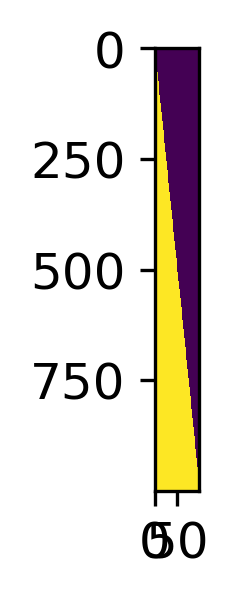

In [9]:
u = Heaviside()
X = u(x(), mu())
plt.imshow(X, interpolation="nearest")

svd_basis = SVD(X)
trig_basis = Trigonometric(x)
greedy_basis = Greedy(X, r=r)
lna_basis = LNA(u, x)
lpf_basis = LPF(x)

In this case, the left singular values can be described analytically with orthogonal sine functions, where the phase length $ \omega = \frac{2  \pi }{4 T}(2 i+1) $ and the amplitude $A = 2 \sqrt{\Delta x} sin(\frac{\pi}{4})$. Note the similarity to the fourier series, where ...

$\varphi_i = A sin(\omega x)$

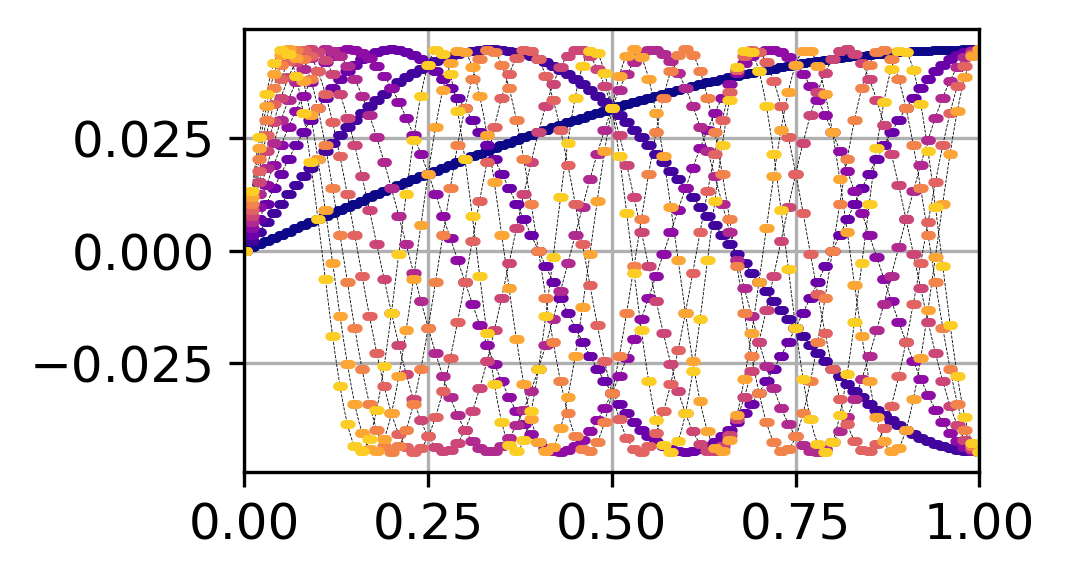

In [10]:
U = svd_basis.U
U_trig = trig_basis.U

fig, ax = plt.subplots()
for i in range(10):
    ax.plot(x(), U_trig[:, i], "k--", lw=.2)
plot_modes(x(), U, r=10)
plt.show()

The right singular values can be described analytically too with orthogonal cosine functions, with the same phase lengths and the amplitude $A = 2 \sqrt{\Delta \mu} sin(\frac{\pi}{4})$.

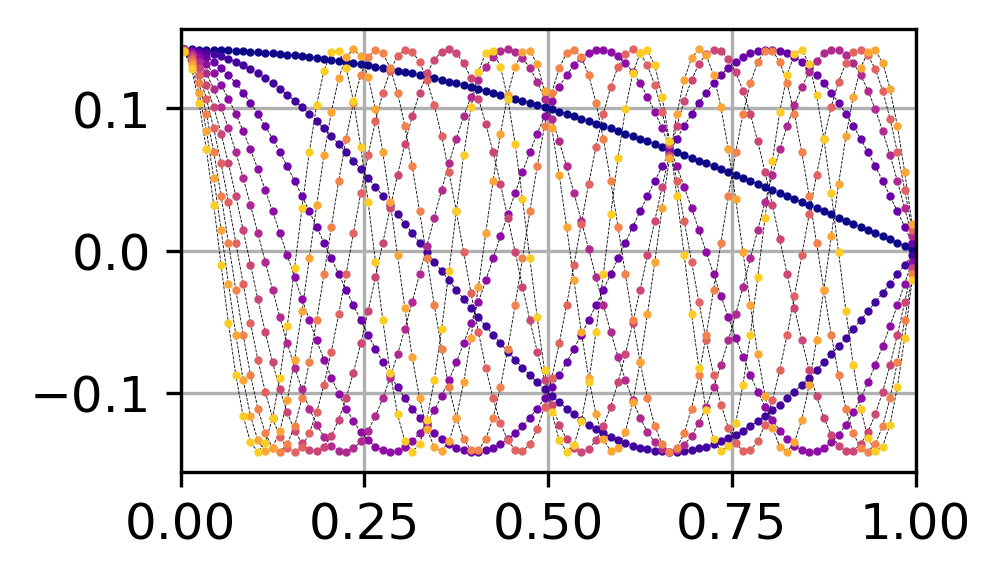

In [11]:
VT = svd_basis.VT
V_trig = Trigonometric(mu, fun=np.cos).U

fig, ax = plt.subplots()
for i in range(10):
    ax.plot(mu(), V_trig[:, i], "k--", lw=.2)
plot_modes(mu(), VT.T, r=10)
plt.show()

singular values decay with 1/n

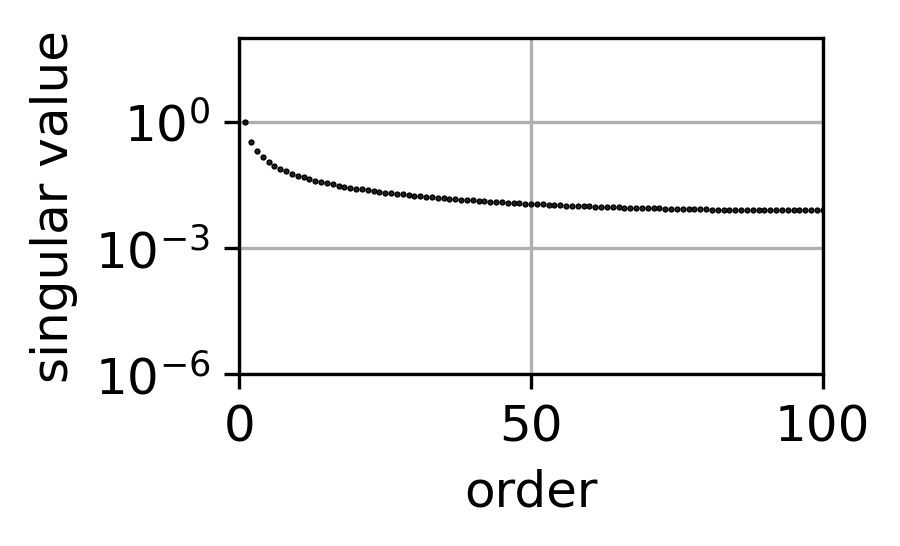

In [12]:
S = svd_basis.S
plot_singular_values(S)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


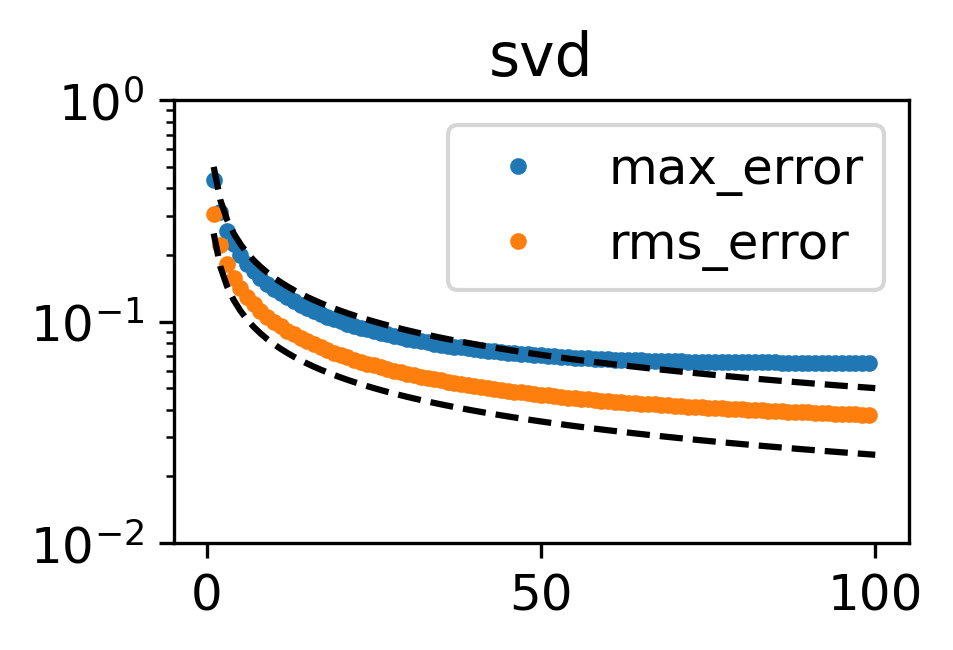

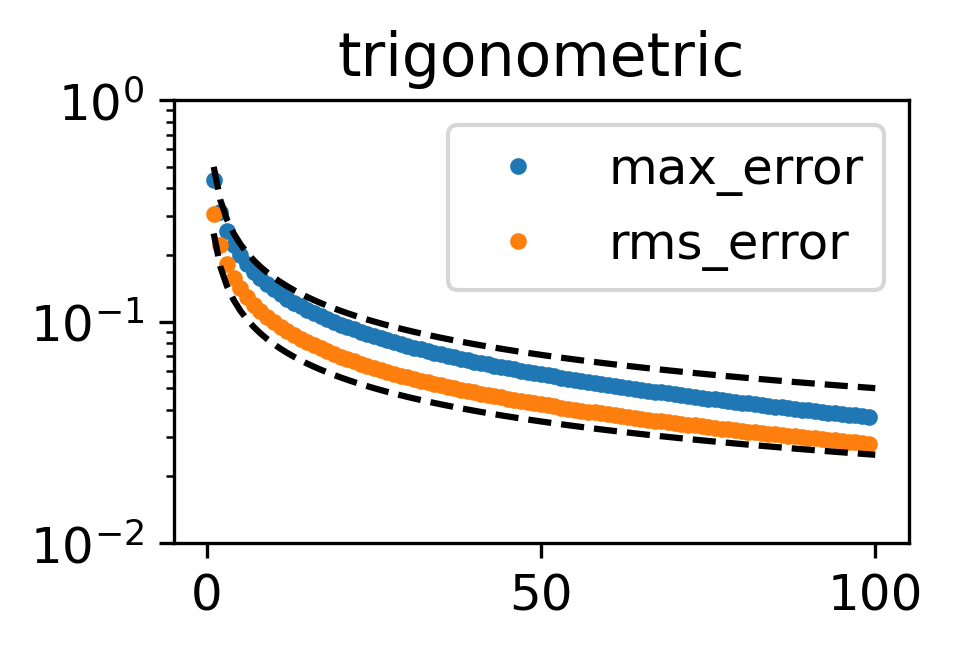

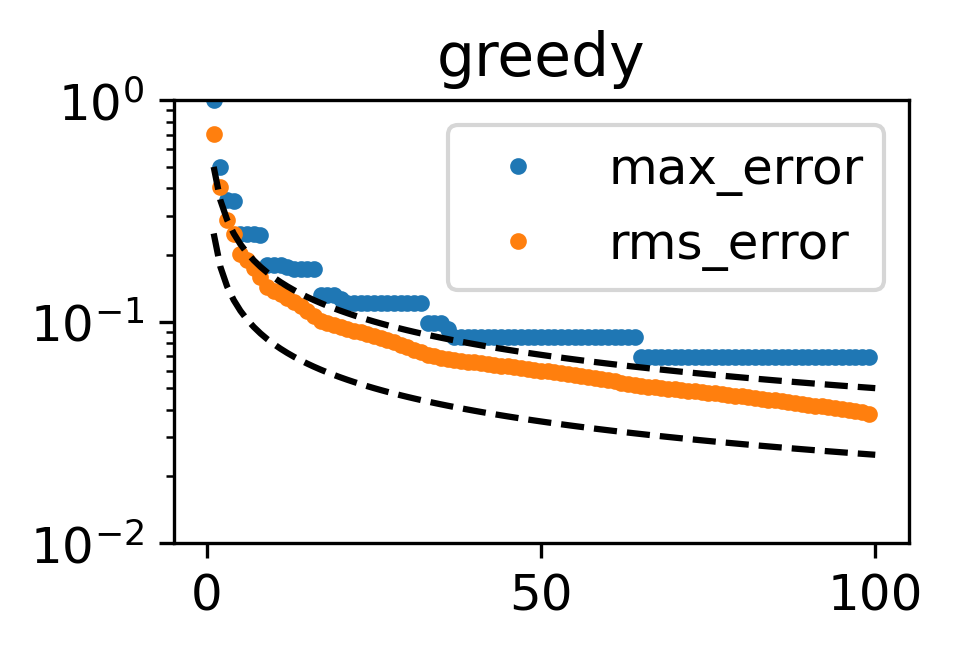

In [ ]:
mu = Domain([0, 1], 1000)
X_test = u(x(), mu())

for basis in [svd_basis, trig_basis, greedy_basis, lna_basis, lpf_basis]:

    rms_error, max_error = basis.calc_error(X_test, r)
    
    ax = plot_error(rms_error, max_error)
    nn = np.arange(1, r+1)
    ax.plot(nn, 1/(2*nn**.5), "k--", label="1/(2sqrt(n)")
    ax.plot(nn, 1/(4*nn**.5), "k--", label="1/(4sqrt(n)")
    ax.set_ylim(1/100, 1)
    #ax.set_xlim(0, 50)
    plt.title(basis.name)
    plt.show()

In [ ]:
X_test.shape


max error for this basis can bee computed. Not the Kol n-width, since there might exist a better basis that minimizes the max error.
We can test different sets of basis vectors.
The greedy basis is known to approximate the n-width in some cases, see [ref]

## Ramp function
is continuous, but not differentiable at $x = t +- epsilon$, so it is of class $C^0$

In [ ]:
epsilon = 0.025

In [ ]:
class Ramp(Function):
    name = "ramp"

    def __init__(self, epsilon):
        self.eps = epsilon
        return

    def u(self, x, mu):
        eps = self.eps
        y = .5+1/(2*eps)*(x-mu)
        y[y < 0] = 0
        y[y > 1] = 1
        return y

u = Ramp(epsilon)
X = u(x(), mu())
plt.imshow(X, interpolation="nearest")

svd_basis = SVD(X)
trig_basis = Trigonometric(x)
greedy_basis = Greedy(X, r=r)
lna_basis = LNA(u, x)
lpf_basis = LPF(x)

In [ ]:
mu = Domain([0, 1], 1000)
X_test = u(x(), mu())

for basis in [svd_basis, trig_basis, greedy_basis, lna_basis, lpf_basis]:

    rms_error, max_error = basis.calc_error(X_test, r)
    
    ax = plot_error(rms_error, max_error)
    nn = np.arange(1, r+1)
    ax.plot(nn, 1/(2*nn**.5), "k--", label="1/(2sqrt(n)")
    ax.plot(nn, 1/(4*nn**.5), "k--", label="1/(4sqrt(n)")
    #ax.set_ylim(1/100, 1)
    #ax.set_xlim(0, 50)
    plt.title(basis.name)
    plt.show()

## Smooth jump with the first derivative being continuous
is continuous and once differentiable, so it is of class $C^1$

In [ ]:
class SmoothJump(Function):
    name = "smooth jump"

    def __init__(self, epsilon):
        self.eps = epsilon
        return

    def u(self, x, mu):
        epsilon = self.eps
        y = np.zeros_like(x)
        intervall1 = x <= (mu-epsilon)
        intervall2 = ((mu-epsilon) <= x) & (x <= mu)
        intervall3 = (mu <= x) & (x <= (mu+epsilon))
        intervall4 = (mu+epsilon) <= x
        y[intervall1] = 0
        y[intervall2] = ((x[intervall2]-(mu-epsilon))/epsilon)**2 / 2
        y[intervall3] = 1-((x[intervall3]-(mu+epsilon))/epsilon)**2 / 2
        y[intervall4] = 1
        return y

In [ ]:
u = SmoothJump(epsilon)
X = u(x(), mu())
plt.imshow(X, interpolation="nearest")

svd_basis = SVD(X)
trig_basis = Trigonometric(x)
greedy_basis = Greedy(X, r=r)
lna_basis = LNA(u, x)
lpf_basis = LPF(x)

In [ ]:
mu = Domain([0, 1], 1000)
X_test = u(x(), mu())

for basis in [svd_basis, trig_basis, greedy_basis, lna_basis, lpf_basis]:

    rms_error, max_error = basis.calc_error(X_test, r)
    
    ax = plot_error(rms_error, max_error)
    nn = np.arange(1, r+1)
    ax.plot(nn, 1/(2*nn**.5), "k--", label="1/(2sqrt(n)")
    ax.plot(nn, 1/(4*nn**.5), "k--", label="1/(4sqrt(n)")
    #ax.set_ylim(1/100, 1)
    #ax.set_xlim(0, 50)
    plt.title(basis.name)
    plt.show()

## Sigmoid function
is continuous and infinitively differentiable, so it is of class $C^\inf$

In [ ]:
class Sigmoid(Function):
    name = "sigmoid"

    def __init__(self, a):
        self.a = a
        return

    def u(self, x, mu):
        a = self.a
        return 1.0 / (1+np.e**(-(x-mu)*a))

In [ ]:
def fit_sigmoid(eps):
    M = 200
    tt = np.linspace(0, 1, M)
    yy = smooth_jump(tt, 0.5, eps)
    popt, pcov = curve_fit(sigmoid, tt, yy, [0.5, 50])
    t, a = popt
    yy_hat = sigmoid(tt, t, a)
    fig, ax = plt.subplots()
    plt.plot(tt, yy, "g.")
    plt.plot(tt, yy_hat, "r.")
    plt.show()
    return a

a = fit_sigmoid(epsilon)

In [ ]:
u = SmoothJump(a)
X = u(x(), mu())
plt.imshow(X, interpolation="nearest")

svd_basis = SVD(X)
trig_basis = Trigonometric(x)
greedy_basis = Greedy(X, r=r)
lna_basis = LNA(u, x)
lpf_basis = LPF(x)

In [ ]:
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(x, U_trig[:, i], "k--", lw=.2)
plot_modes(x, U, r=10)
plt.xlim(-.1, 1.1)
plt.show()
print(rms(U[:, :10]-U_trig[:, :10]))

In [ ]:
plt.imshow(X, interpolation="nearest")

In [ ]:
U_greedy = greedy_basis(X, R)

def reduced_basis_trig(r): return truncate(U_trig, r)
def reduced_basis_greedy(r): return truncate(U_greedy, r)
def reduced_basis_svd(r): return truncate(U, r)
def reduced_basis_lna(r): return local_neighbours_average(x, u_ramp, r)
def reduced_basis_pulse(r): return local_constant_basis(x, r)

print("calculating error")
ttls = ["trigonometric basis", "greedy basis", "svd basis", "local neighbours average basis", "locally constant basis"]
for i, rb in enumerate([reduced_basis_trig, reduced_basis_svd, reduced_basis_greedy,
          reduced_basis_lna, reduced_basis_pulse]):
    print(i)
    rms_error, max_error = calc_error(rb, X, R)
    
    ax = plot_error(rms_error, max_error)
    nn = np.arange(1, R+1)
    ax.plot(nn, 1/nn, "k--", label="1/n")
    #ax.set_ylim(1/100, 1)
    ax.set_xlim(0, R)
    plt.title(ttls[i])
    plt.show()